# **🔵 Fase 2: Preprocesamiento y Extracción de Características**

# 2.1 Importar librerias

In [18]:
import os
import librosa
import librosa.display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

# 2.2 Cargar Datasets

In [19]:
# Ruta del dataset
dataset_dir = '/kaggle/input/depression-dataset/dataset-depression'

# Etiquetas según carpeta
label_map = {
    'depression1': 1,
    'depression2': 1,
    'normal1': 0,
    'normal2': 0
}

data = []
for folder_name in os.listdir(dataset_dir):
    folder_path = os.path.join(dataset_dir, folder_name)
    if os.path.isdir(folder_path) and folder_name in label_map:
        label = label_map[folder_name]
        for file_name in os.listdir(folder_path):
            if file_name.endswith('.wav'):
                relative_path = os.path.join(folder_name, file_name)
                data.append([relative_path, label])

# Guardar CSV
df = pd.DataFrame(data, columns=['audio_path', 'label'])
csv_path = '/kaggle/working/deteccion_riesgo_suicidio.csv'
df.to_csv(csv_path, index=False)

print(f"✅ CSV generado en: {csv_path}")


✅ CSV generado en: /kaggle/working/deteccion_riesgo_suicidio.csv


In [20]:
# Leer CSV generado
df = pd.read_csv('/kaggle/working/deteccion_riesgo_suicidio.csv')
df.head()


audio_path  label
0   depression1/OAF_germ_sad.wav      1
1  depression1/OAF_thumb_sad.wav      1
2    depression1/OAF_rag_sad.wav      1
3   depression1/OAF_mood_sad.wav      1
4   depression1/OAF_nice_sad.wav      1

# 2.3 Generar audio y Espectrograma 

🎧 Reproduciendo audio:


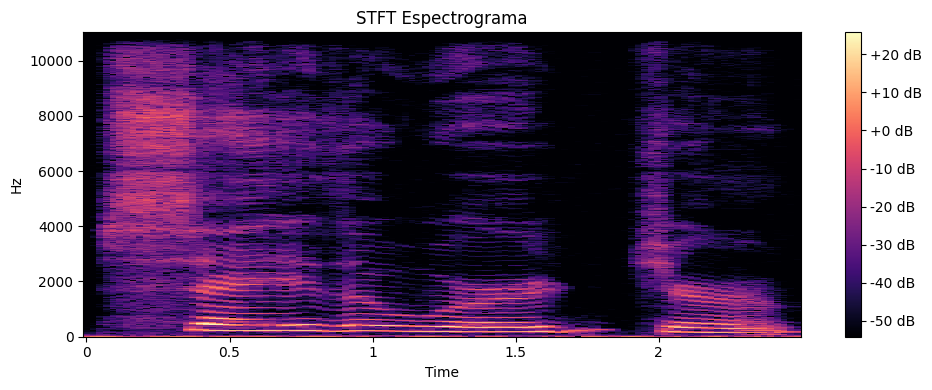

In [21]:
# Crear carpeta de salida
output_dir = '/kaggle/working/espectrogramas_stft'
os.makedirs(output_dir, exist_ok=True)

# Seleccionamos un audio al azar
sample_path = os.path.join(dataset_dir, df.iloc[0]['audio_path'])

# Cargar audio
y, sr = librosa.load(sample_path)

# Mostrar reproductor de audio
print("🎧 Reproduciendo audio:")
ipd.display(ipd.Audio(sample_path))

# Espectrograma
plt.figure(figsize=(10, 4))
D = librosa.stft(y)
S_db = librosa.amplitude_to_db(abs(D))
librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar(format="%+2.0f dB")
plt.title('STFT Espectrograma')
plt.tight_layout()
plt.show()

# 2.4 Generar espectrogramas STFT para todos los audios

In [22]:
import pandas as pd
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt

# Cargar el archivo CSV con rutas y etiquetas
csv_path = "/kaggle/working/deteccion_riesgo_suicidio.csv"
df = pd.read_csv(csv_path)

# Carpeta de entrada y salida
input_dir = '/kaggle/input/depression-dataset/dataset-depression'
output_dir = '/kaggle/working/espectrogramas_stft/'

# Proceso en lote: recorrer todos los audios y guardar espectrogramas
for idx, row in df.iterrows():
    relative_path = row['audio_path']
    audio_path = os.path.join(input_dir, relative_path)
    output_image_path = os.path.join(output_dir, relative_path.replace('.wav', '.png').replace('/', '_'))

    try:
        y, sr = librosa.load(audio_path, sr=None)
        D = librosa.stft(y)
        S_db = librosa.amplitude_to_db(abs(D))

        plt.figure(figsize=(3, 3))
        librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='hz', cmap='inferno')
        plt.axis('off')
        plt.tight_layout()
        plt.savefig(output_image_path, bbox_inches='tight', pad_inches=0)
        plt.close()

        print(f"✅ Espectrograma generado: {output_image_path}")
    except Exception as e:
        print(f"❌ Error procesando {audio_path}: {e}")

✅ Espectrograma generado: /kaggle/working/espectrogramas_stft/depression1_OAF_germ_sad.png
✅ Espectrograma generado: /kaggle/working/espectrogramas_stft/depression1_OAF_thumb_sad.png
✅ Espectrograma generado: /kaggle/working/espectrogramas_stft/depression1_OAF_rag_sad.png
✅ Espectrograma generado: /kaggle/working/espectrogramas_stft/depression1_OAF_mood_sad.png
✅ Espectrograma generado: /kaggle/working/espectrogramas_stft/depression1_OAF_nice_sad.png
✅ Espectrograma generado: /kaggle/working/espectrogramas_stft/depression1_OAF_perch_sad.png
✅ Espectrograma generado: /kaggle/working/espectrogramas_stft/depression1_OAF_boat_sad.png
✅ Espectrograma generado: /kaggle/working/espectrogramas_stft/depression1_OAF_mop_sad.png
✅ Espectrograma generado: /kaggle/working/espectrogramas_stft/depression1_OAF_thought_sad.png
✅ Espectrograma generado: /kaggle/working/espectrogramas_stft/depression1_OAF_goose_sad.png
✅ Espectrograma generado: /kaggle/working/espectrogramas_stft/depression1_OAF_dime_sad

In [23]:
# Contar total de registros en el CSV
total_audios_csv = len(df)

# Contar total de imágenes PNG generadas
total_espectrogramas = len([f for f in os.listdir(output_dir) if f.endswith('.png')])

print(f"🎧 Audios en CSV: {total_audios_csv}")
print(f"🖼️ Espectrogramas generados: {total_espectrogramas}")

if total_audios_csv == total_espectrogramas:
    print("✅ Todo está bien: se generaron todos los espectrogramas.")
else:
    print("⚠️ Hay una diferencia. Puede que falten algunos espectrogramas.")

🎧 Audios en CSV: 800
🖼️ Espectrogramas generados: 800
✅ Todo está bien: se generaron todos los espectrogramas.


# 2.5 Extraer caracteristicas acústicas por cada audio y guardarlas en un archivo # 

In [24]:
import numpy as np
import librosa.feature

# Función para extraer características
def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=None)

    # Extraer MFCCs
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    mfccs_mean = np.mean(mfccs, axis=1)

    # Chroma
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    chroma_mean = np.mean(chroma, axis=1)

    # Zero Crossing Rate
    zcr = librosa.feature.zero_crossing_rate(y)
    zcr_mean = np.mean(zcr)

    # Spectral Centroid
    centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
    centroid_mean = np.mean(centroid)

    # RMS
    rms = librosa.feature.rms(y=y)
    rms_mean = np.mean(rms)

    # Concatenar todo en un vector
    features = np.concatenate((mfccs_mean, chroma_mean, [zcr_mean, centroid_mean, rms_mean]))
    return features

# Aplicar a todos los audios
features_list = []
for i, row in df.iterrows():
    audio_path = os.path.join(dataset_dir, row['audio_path'])
    label = row['label']
    try:
        features = extract_features(audio_path)
        features_list.append(np.append(features, label))
        if i % 100 == 0:
            print(f"✅ Procesado {i} / {len(df)} audios")
    except Exception as e:
        print(f"⚠️ Error con {audio_path}: {e}")

# Crear DataFrame
columns = [f'mfcc_{i+1}' for i in range(13)] + \
          [f'chroma_{i+1}' for i in range(12)] + \
          ['zcr', 'centroid', 'rms', 'label']

features_df = pd.DataFrame(features_list, columns=columns)

# Guardar en CSV
features_csv_path = '/kaggle/working/features_audio.csv'
features_df.to_csv(features_csv_path, index=False)

print(f"✅ CSV de características guardado en: {features_csv_path}")


✅ Procesado 0 / 800 audios
✅ Procesado 100 / 800 audios
✅ Procesado 200 / 800 audios
✅ Procesado 300 / 800 audios
✅ Procesado 400 / 800 audios
✅ Procesado 500 / 800 audios
✅ Procesado 600 / 800 audios
✅ Procesado 700 / 800 audios
✅ CSV de características guardado en: /kaggle/working/features_audio.csv


# 2.6 Normalización o Estandarización de los datos

In [26]:
from sklearn.preprocessing import StandardScaler

# Leer el CSV de características
features_df = pd.read_csv('/kaggle/working/features_audio.csv')

# Separar características y etiquetas
X = features_df.drop('label', axis=1)
y = features_df['label']

# Normalizar
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reconstruir DataFrame normalizado con etiqueta
features_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)
features_scaled_df['label'] = y

# Guardar CSV final
final_csv_path = '/kaggle/working/features_audio_normalizado.csv'
features_scaled_df.to_csv(final_csv_path, index=False)

print(f"✅ Datos normalizados guardados en: {final_csv_path}")


✅ Datos normalizados guardados en: /kaggle/working/features_audio_normalizado.csv


# **🔵 Fase 3: Modelos de Redes Neuronales**

# Dividir los datos en conjuntos de entrenamiento y prueba (train/test split).

In [27]:
from sklearn.model_selection import train_test_split

# Cargar CSV normalizado
df = pd.read_csv('/kaggle/working/features_audio_normalizado.csv')

# Separar características y etiquetas
X = df.drop('label', axis=1).values
y = df['label'].values

# Dividir en train (80%) y test (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"✅ Tamaño conjunto de entrenamiento: {X_train.shape[0]}")
print(f"✅ Tamaño conjunto de prueba: {X_test.shape[0]}")


✅ Tamaño conjunto de entrenamiento: 640
✅ Tamaño conjunto de prueba: 160


# 3.1 Entrenamiento del Modelo MLP

In [28]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Solo errores críticos
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score

# 1. Crear el modelo MLP
model_mlp = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Salida binaria: 0 (normal), 1 (depresión)
])

# 2. Compilar
model_mlp.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

# 3. Entrenar
history_mlp = model_mlp.fit(X_train, y_train, 
                            epochs=30, 
                            batch_size=32, 
                            validation_split=0.2,
                            verbose=1)

# 4. Evaluar en conjunto de prueba
y_pred_prob = model_mlp.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

acc = accuracy_score(y_test, y_pred)
print(f"✅ Precisión del modelo MLP en test: {acc:.4f}")


Epoch 1/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.6794 - loss: 0.5900 - val_accuracy: 0.9688 - val_loss: 0.2140
Epoch 2/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9841 - loss: 0.1648 - val_accuracy: 0.9922 - val_loss: 0.0393
Epoch 3/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0361 - val_accuracy: 0.9922 - val_loss: 0.0222
Epoch 4/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9981 - loss: 0.0081 - val_accuracy: 0.9922 - val_loss: 0.0147
Epoch 5/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0073 - val_accuracy: 0.9844 - val_loss: 0.0137
Epoch 6/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0033 - val_accuracy: 0.9844 - val_loss: 0.0151
Epoch 7/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9937 - loss: 0.0068 - val_accuracy: 0.9844 - val_loss: 0.0120
Epoch 8/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0022 - val_accuracy: 0.9922 - val_loss

# 3.2 Entrenamiento del modelo CNN (Convolutional Neural Network)

In [29]:
# Ocultar mensajes molestos de TensorFlow (opcional pero recomendado)
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np

# Cargar datos
df = pd.read_csv('/kaggle/working/features_audio_normalizado.csv')

# Separar características (X) y etiquetas (y)
X = df.drop('label', axis=1).values
y = df['label'].values

# Codificar etiquetas
encoder = LabelEncoder()
y = encoder.fit_transform(y)

# Reshape de X para Conv1D: (samples, timesteps, features)
X = np.expand_dims(X, axis=2)

# Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Crear modelo CNN
model_cnn = Sequential([
    Conv1D(32, kernel_size=3, activation='relu', input_shape=(X.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    
    Conv1D(64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Para clasificación binaria
])

# Compilar modelo
model_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenar modelo
early_stop = EarlyStopping(patience=5, restore_best_weights=True)
history = model_cnn.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

# Evaluar en test
loss, accuracy = model_cnn.evaluate(X_test, y_test)
print(f"✅ Precisión del modelo CNN en test: {accuracy:.4f}")


Epoch 1/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.5925 - loss: 0.6601 - val_accuracy: 0.9766 - val_loss: 0.4576
Epoch 2/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9209 - loss: 0.4277 - val_accuracy: 0.9844 - val_loss: 0.1979
Epoch 3/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9743 - loss: 0.2114 - val_accuracy: 0.9922 - val_loss: 0.0728
Epoch 4/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9796 - loss: 0.1061 - val_accuracy: 1.0000 - val_loss: 0.0336
Epoch 5/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9903 - loss: 0.0422 - val_accuracy: 1.0000 - val_loss: 0.0197
Epoch 6/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9924 - loss: 0.0410 - val_accuracy: 1.0000 - val_loss: 0.0143
Epoch 7/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9979 - loss: 0.0254 - val_accuracy: 1.0000 - val_loss: 0.0110
Epoch 8/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9914 - loss: 0.0272 - val_accuracy: 1.0000 - val_los

# 3.3 Entrenamiento del modelo RNN

In [30]:
# ✅ Redimensionar X_train para RNN con formato (samples, timesteps, features)
n_steps = 10
n_inputs = 2

# 🔢 Aplanar y calcular total de muestras posibles
X_flat = X_train.reshape(-1)
total_samples = len(y_train)  # usar 640 como tope, ya que y_train es el límite

X_train_rnn = X_flat[:total_samples * n_steps * n_inputs].reshape(total_samples, n_steps, n_inputs)
y_train_rnn = y_train[:total_samples]  # garantizar misma longitud

# ✅ Verificar formas
print("✅ X_train_rnn shape:", X_train_rnn.shape)
print("✅ y_train_rnn shape:", y_train_rnn.shape)


✅ X_train_rnn shape: (640, 10, 2)
✅ y_train_rnn shape: (640,)


In [33]:
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense

# Parámetros usados antes
n_steps = 10
n_inputs = 2

# ✅ Definir modelo RNN
model_rnn = Sequential()
model_rnn.add(SimpleRNN(32, input_shape=(n_steps, n_inputs)))
model_rnn.add(Dense(1, activation='sigmoid'))

# ✅ Compilar modelo
model_rnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# ✅ Mostrar resumen
model_rnn.summary()


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)               │ (None, 32)                  │           1,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,153 (4.50 KB)

 Trainable params: 1,153 (4.50 KB)

 Non-trainable params: 0 (0.00 B)

In [34]:
print("🏃 Entrenando modelo RNN...")
history_rnn = model_rnn.fit(
    X_train_rnn, y_train_rnn,
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

🏃 Entrenando modelo RNN...
Epoch 1/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.5181 - loss: 0.7369 - val_accuracy: 0.5234 - val_loss: 0.7265
Epoch 2/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5429 - loss: 0.6937 - val_accuracy: 0.4922 - val_loss: 0.7275
Epoch 3/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5439 - loss: 0.6941 - val_accuracy: 0.5000 - val_loss: 0.7255
Epoch 4/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6215 - loss: 0.6594 - val_accuracy: 0.5000 - val_loss: 0.7259
Epoch 5/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5732 - loss: 0.6761 - val_accuracy: 0.5000 - val_loss: 0.7227
Epoch 6/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5779 - loss: 0.6623 - val_accuracy: 0.4922 - val_loss: 0.7280
Epoch 7/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5674 - loss: 0.6693 - val_accuracy: 0.4844 - val_loss: 0.7274
Epoch 8/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6131 - loss: 0.6525 - val_

# 3.4 Entrenamiento de Modelo LSTM

In [32]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

# 4️⃣ Definir arquitectura del modelo LSTM
model_lstm = Sequential()
model_lstm.add(LSTM(64, input_shape=(n_steps, n_inputs)))
model_lstm.add(Dense(32, activation='relu'))
model_lstm.add(Dense(1, activation='sigmoid'))

# Compilar el modelo
model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 🏃 Entrenar el modelo
print("🏃 Entrenando modelo LSTM...")
history_lstm = model_lstm.fit(
    X_train_rnn, y_train_rnn,
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

🏃 Entrenando modelo LSTM...
Epoch 1/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.4668 - loss: 0.6936 - val_accuracy: 0.4688 - val_loss: 0.6950
Epoch 2/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5279 - loss: 0.6910 - val_accuracy: 0.4688 - val_loss: 0.6949
Epoch 3/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5269 - loss: 0.6914 - val_accuracy: 0.4453 - val_loss: 0.6965
Epoch 4/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4752 - loss: 0.6915 - val_accuracy: 0.5078 - val_loss: 0.6949
Epoch 5/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5531 - loss: 0.6886 - val_accuracy: 0.5156 - val_loss: 0.6945
Epoch 6/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5449 - loss: 0.6846 - val_accuracy: 0.5000 - val_loss: 0.6963
Epoch 7/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5498 - loss: 0.6872 - val_accuracy: 0.5000 - val_loss: 0.6954
Epoch 8/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5703 - loss: 0.682

# 3.5 Entrenamiento del modelo GRU

In [35]:
from keras.models import Sequential
from keras.layers import GRU, Dense

# 5️⃣ Definir arquitectura del modelo GRU
model_gru = Sequential()
model_gru.add(GRU(64, input_shape=(n_steps, n_inputs)))
model_gru.add(Dense(32, activation='relu'))
model_gru.add(Dense(1, activation='sigmoid'))

# Compilar el modelo
model_gru.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 🏃 Entrenar el modelo
print("🏃 Entrenando modelo GRU...")
history_gru = model_gru.fit(
    X_train_rnn, y_train_rnn,
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)


🏃 Entrenando modelo GRU...
Epoch 1/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.5028 - loss: 0.6936 - val_accuracy: 0.5234 - val_loss: 0.6977
Epoch 2/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5367 - loss: 0.6873 - val_accuracy: 0.5078 - val_loss: 0.6976
Epoch 3/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5449 - loss: 0.6880 - val_accuracy: 0.5156 - val_loss: 0.6965
Epoch 4/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5507 - loss: 0.6876 - val_accuracy: 0.4844 - val_loss: 0.6992
Epoch 5/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5347 - loss: 0.6843 - val_accuracy: 0.5469 - val_loss: 0.6968
Epoch 6/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5689 - loss: 0.6791 - val_accuracy: 0.5391 - val_loss: 0.6964
Epoch 7/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5958 - loss: 0.6811 - val_accuracy: 0.5469 - val_loss: 0.6960
Epoch 8/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6162 - loss: 0.6770

# 3.6 Entrenamiento del modelo Transformer

In [36]:
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Dense, LayerNormalization, Dropout, MultiHeadAttention, GlobalAveragePooling1D, Add

# 6️⃣ Definir arquitectura del Transformer
inputs = Input(shape=(n_steps, n_inputs))  # (10, 2)

# 🔧 Proyección inicial a dimensión d_model=64
x = Dense(64)(inputs)

# Capa de atención multi-cabeza
attention = MultiHeadAttention(num_heads=2, key_dim=32)(x, x)
x = Add()([x, attention])  # residual
x = LayerNormalization(epsilon=1e-6)(x)

# Capa feed-forward
ff = Dense(64, activation='relu')(x)
ff = Dropout(0.1)(ff)
x = Add()([x, ff])  # residual
x = LayerNormalization(epsilon=1e-6)(x)

# Pooling y salida
x = GlobalAveragePooling1D()(x)
x = Dense(32, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)

# Crear modelo
model_transformer = Model(inputs=inputs, outputs=outputs)

# Compilar
model_transformer.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 🏃 Entrenar el modelo
print("🏃 Entrenando modelo Transformer...")
history_transformer = model_transformer.fit(
    X_train_rnn, y_train_rnn,
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)


🏃 Entrenando modelo Transformer...
Epoch 1/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accuracy: 0.5039 - loss: 0.7347 - val_accuracy: 0.4688 - val_loss: 0.6958
Epoch 2/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5210 - loss: 0.6922 - val_accuracy: 0.5000 - val_loss: 0.6930
Epoch 3/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5357 - loss: 0.6911 - val_accuracy: 0.5078 - val_loss: 0.6928
Epoch 4/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5386 - loss: 0.6875 - val_accuracy: 0.5625 - val_loss: 0.6923
Epoch 5/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5253 - loss: 0.6872 - val_accuracy: 0.5391 - val_loss: 0.6928
Epoch 6/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5674 - loss: 0.6767 - val_accuracy: 0.5078 - val_loss: 0.6964
Epoch 7/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5763 - loss: 0.6823 - val_accuracy: 0.4688 - val_loss: 0.6951
Epoch 8/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5758 - loss

# 🔵 FASE 4: Evaluación de Modelos

Evaluar los modelos con métricas en el set de prueba (X_test_rnn, y_test_rnn):

1. AccuracyF1
2. Score
3. Matriz de confusión
4. Curva ROC y AUC
5. Curva Precision-Recall

# Graficar accuracy y LOSS del modelo Transformer

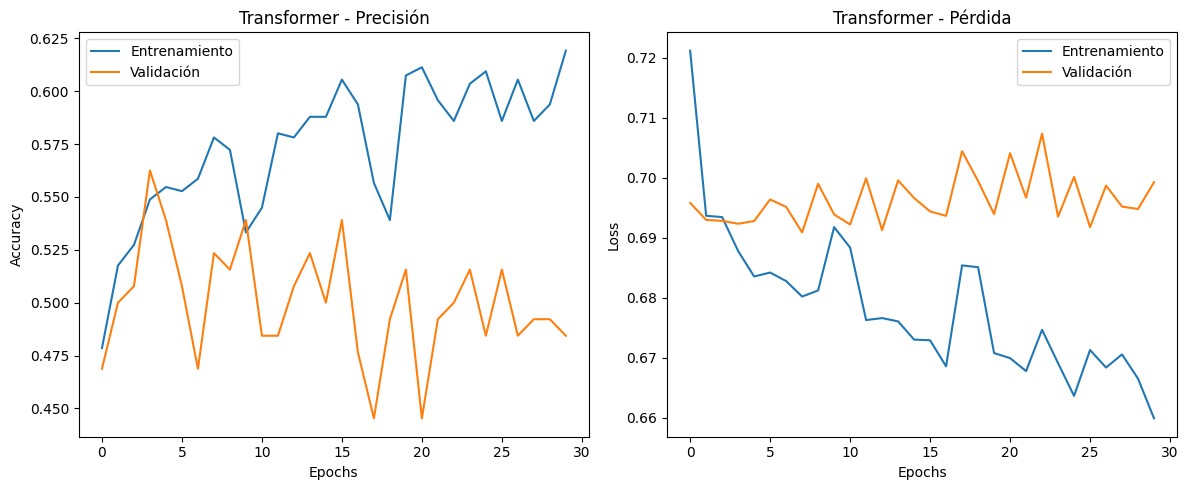

In [37]:
import matplotlib.pyplot as plt

# Graficar accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_transformer.history['accuracy'], label='Entrenamiento')
plt.plot(history_transformer.history['val_accuracy'], label='Validación')
plt.title('Transformer - Precisión')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Graficar loss
plt.subplot(1, 2, 2)
plt.plot(history_transformer.history['loss'], label='Entrenamiento')
plt.plot(history_transformer.history['val_loss'], label='Validación')
plt.title('Transformer - Pérdida')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


# Evaluación del modelo RNN

In [46]:
# 🔁 Redimensionar X_test para RNN (igual que en entrenamiento)
X_test_flat = X_test.reshape(-1)
total_samples_test = len(y_test)

X_test_rnn = X_test_flat[:total_samples_test * n_steps * n_inputs].reshape(total_samples_test, n_steps, n_inputs)
y_test_rnn = y_test[:total_samples_test]  # asegurar mismo tamaño

# ✅ Verificar forma
print("✅ X_test_rnn shape:", X_test_rnn.shape)
print("✅ y_test_rnn shape:", y_test_rnn.shape)

✅ X_test_rnn shape: (160, 10, 2)
✅ y_test_rnn shape: (160,)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step  
🔵 Modelo RNN - Accuracy: 0.4938, F1 Score: 0.4906
Matriz de Confusión:


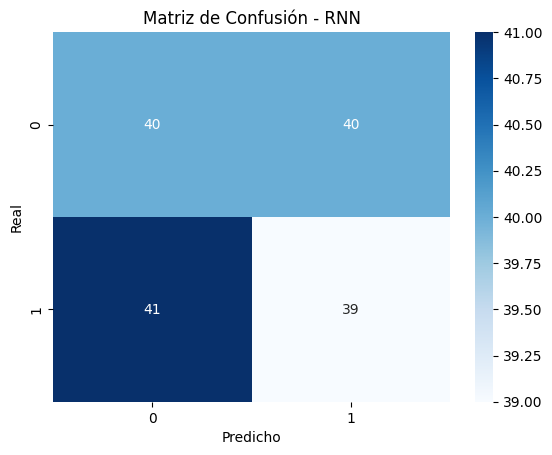

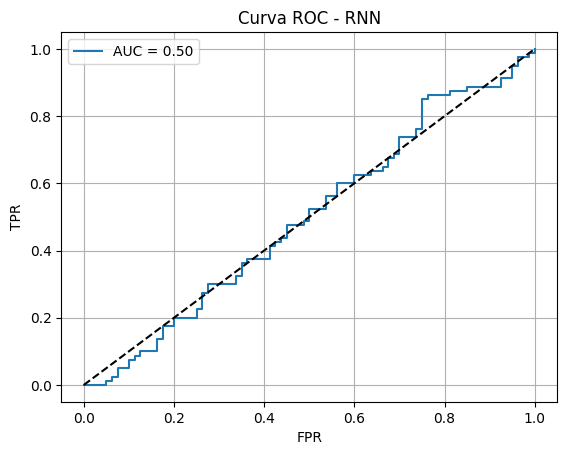

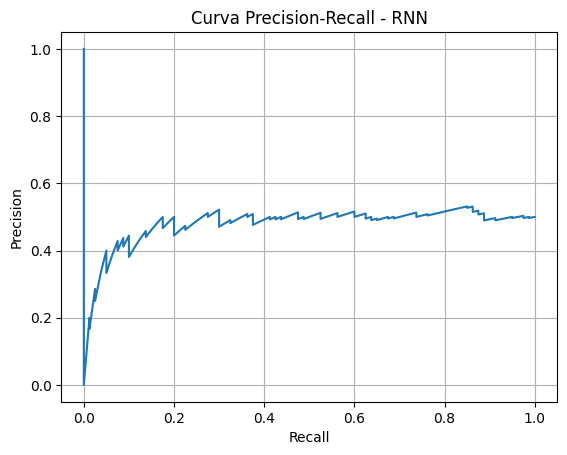

In [49]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns

# ✅ Evaluación del modelo RNN con datos redimensionados
y_pred_rnn = model_rnn.predict(X_test_rnn)
y_pred_rnn_labels = (y_pred_rnn > 0.5).astype("int32")

acc_rnn = accuracy_score(y_test_rnn, y_pred_rnn_labels)
f1_rnn = f1_score(y_test_rnn, y_pred_rnn_labels)
cm_rnn = confusion_matrix(y_test_rnn, y_pred_rnn_labels)

print(f"🔵 Modelo RNN - Accuracy: {acc_rnn:.4f}, F1 Score: {f1_rnn:.4f}")
print("Matriz de Confusión:")
sns.heatmap(cm_rnn, annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de Confusión - RNN")
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.show()

# ✅ Curva ROC
fpr, tpr, _ = roc_curve(y_test_rnn, y_pred_rnn)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('Curva ROC - RNN')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.grid()
plt.show()

# ✅ Curva Precision-Recall
precision, recall, _ = precision_recall_curve(y_test_rnn, y_pred_rnn)
plt.plot(recall, precision)
plt.title('Curva Precision-Recall - RNN')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.show()


# Evaluación del modelo LSTM

In [40]:
# Evaluación del modelo LSTM
y_pred_lstm = model_lstm.predict(X_test)
y_pred_lstm_labels = (y_pred_lstm > 0.5).astype("int32")

acc_lstm = accuracy_score(y_test, y_pred_lstm_labels)
f1_lstm = f1_score(y_test, y_pred_lstm_labels)
cm_lstm = confusion_matrix(y_test, y_pred_lstm_labels)

print(f"🟠 Modelo LSTM - Accuracy: {acc_lstm:.4f}, F1 Score: {f1_lstm:.4f}")
print("Matriz de Confusión:")
sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Oranges')
plt.title("Matriz de Confusión - LSTM")
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.show()

# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_lstm)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('Curva ROC - LSTM')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.grid()
plt.show()

# Curva Precision-Recall
precision, recall, _ = precision_recall_curve(y_test, y_pred_lstm)
plt.plot(recall, precision)
plt.title('Curva Precision-Recall - LSTM')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.show()


ValueError: Exception encountered when calling LSTMCell.call().

[1mDimensions must be equal, but are 1 and 2 for '{{node sequential_4_1/lstm_1/lstm_cell_1/MatMul}} = MatMul[T=DT_FLOAT, grad_a=false, grad_b=false, transpose_a=false, transpose_b=false](sequential_4_1/lstm_1/strided_slice_1, sequential_4_1/lstm_1/lstm_cell_1/Cast/ReadVariableOp)' with input shapes: [32,1], [2,256].[0m

Arguments received by LSTMCell.call():
  • inputs=tf.Tensor(shape=(32, 1), dtype=float32)
  • states=('tf.Tensor(shape=(32, 64), dtype=float32)', 'tf.Tensor(shape=(32, 64), dtype=float32)')
  • training=False

# Evaluación del modelo GRU

In [ ]:
# Evaluación del modelo GRU
y_pred_gru = model_gru.predict(X_test)
y_pred_gru_labels = (y_pred_gru > 0.5).astype("int32")

acc_gru = accuracy_score(y_test, y_pred_gru_labels)
f1_gru = f1_score(y_test, y_pred_gru_labels)
cm_gru = confusion_matrix(y_test, y_pred_gru_labels)

print(f"🟡 Modelo GRU - Accuracy: {acc_gru:.4f}, F1 Score: {f1_gru:.4f}")
print("Matriz de Confusión:")
sns.heatmap(cm_gru, annot=True, fmt='d', cmap='YlGnBu')
plt.title("Matriz de Confusión - GRU")
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.show()

# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_gru)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('Curva ROC - GRU')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.grid()
plt.show()

# Curva Precision-Recall
precision, recall, _ = precision_recall_curve(y_test, y_pred_gru)
plt.plot(recall, precision)
plt.title('Curva Precision-Recall - GRU')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.show()


# Evaluación del modelo MLP

In [ ]:
# Evaluación del modelo MLP
y_pred_mlp = model_mlp.predict(X_test)
y_pred_mlp_labels = (y_pred_mlp > 0.5).astype("int32")

acc_mlp = accuracy_score(y_test, y_pred_mlp_labels)
f1_mlp = f1_score(y_test, y_pred_mlp_labels)
cm_mlp = confusion_matrix(y_test, y_pred_mlp_labels)

print(f"🟢 Modelo MLP - Accuracy: {acc_mlp:.4f}, F1 Score: {f1_mlp:.4f}")
print("Matriz de Confusión:")
sns.heatmap(cm_mlp, annot=True, fmt='d', cmap='Greens')
plt.title("Matriz de Confusión - MLP")
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.show()

# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_mlp)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('Curva ROC - MLP')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.grid()
plt.show()

# Curva Precision-Recall
precision, recall, _ = precision_recall_curve(y_test, y_pred_mlp)
plt.plot(recall, precision)
plt.title('Curva Precision-Recall - MLP')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.show()


# Evaluación del modelo CNN

In [ ]:
# Evaluación del modelo CNN
y_pred_cnn = model_cnn.predict(X_test)
y_pred_cnn_labels = (y_pred_cnn > 0.5).astype("int32")

acc_cnn = accuracy_score(y_test, y_pred_cnn_labels)
f1_cnn = f1_score(y_test, y_pred_cnn_labels)
cm_cnn = confusion_matrix(y_test, y_pred_cnn_labels)

print(f"🔴 Modelo CNN - Accuracy: {acc_cnn:.4f}, F1 Score: {f1_cnn:.4f}")
print("Matriz de Confusión:")
sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Reds')
plt.title("Matriz de Confusión - CNN")
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.show()

# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_cnn)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('Curva ROC - CNN')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.grid()
plt.show()

# Curva Precision-Recall
precision, recall, _ = precision_recall_curve(y_test, y_pred_cnn)
plt.plot(recall, precision)
plt.title('Curva Precision-Recall - CNN')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.show()


# Tabla comparativa de resultados (Accuracy y F1 Score)

In [ ]:
# Crear tabla comparativa de métricas
resultados_modelos = {
    'Modelo': ['MLP', 'CNN', 'RNN', 'LSTM', 'GRU', 'Transformer'],
    'Accuracy': [acc_mlp, acc_cnn, acc_rnn, acc_lstm, acc_gru, acc_transformer],
    'F1 Score': [f1_mlp, f1_cnn, f1_rnn, f1_lstm, f1_gru, f1_transformer]
}

df_resultados = pd.DataFrame(resultados_modelos)
df_resultados = df_resultados.sort_values(by='F1 Score', ascending=False).reset_index(drop=True)

# Mostrar tabla
print("🔎 Comparativa de Resultados de Modelos:")
display(df_resultados.style.background_gradient(cmap='YlGnBu').format(precision=4))


# Gráfico comparativo de modelos (Accuracy y F1 Score)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Configurar datos
modelos = ['MLP', 'CNN', 'RNN', 'LSTM', 'GRU', 'Transformer']
accuracy = [acc_mlp, acc_cnn, acc_rnn, acc_lstm, acc_gru, acc_transformer]
f1_scores = [f1_mlp, f1_cnn, f1_rnn, f1_lstm, f1_gru, f1_transformer]

x = np.arange(len(modelos))
width = 0.35

# Crear gráfico de barras
fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, accuracy, width, label='Accuracy', color='skyblue')
bars2 = ax.bar(x + width/2, f1_scores, width, label='F1 Score', color='salmon')

# Personalización
ax.set_xlabel('Modelos')
ax.set_ylabel('Puntaje')
ax.set_title('Comparativa de rendimiento de modelos')
ax.set_xticks(x)
ax.set_xticklabels(modelos)
ax.legend()
ax.set_ylim(0, 1.05)

# Mostrar los valores sobre cada barra
def autolabel(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # Desplazamiento vertical
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(bars1)
autolabel(bars2)

plt.tight_layout()
plt.show()
